## Learning from Isochrones: A machine learning approach to estimating stellar properties

### Part 5 - Estimating the distance of star clusters using duplicate isochrones

##### Luco Buise (s1055446)

---

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as ip
import random as ran

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [2]:
# create training data

isochrones = ["FeH05", "FeH0", "FeH-05", "FeH-10", "FeH-15", "FeH-20", "FeH-25"]

isochrone_values = [0.5, 0, -0.5, -1, -1.5, -2, -2.5]

dist_mod = np.linspace(9,15,61)

Y = np.array([])
X = np.array([])

for i, iso in enumerate(isochrones):

    loga, mag_B, mag_V = np.loadtxt('isochrones/small_data/isoc_' + iso + '.cmd', usecols=(1, 10, 11), unpack=True)
    loga = np.around(loga, decimals=2) 
    
    # find the highest and lowest age in this isochrone
    min_age = min(loga)
    max_age = max(loga)
    steps = ((max_age - min_age) / 0.1) + 1
    
    # create the ages
    ages = np.linspace(min_age, max_age, int(steps))
    ages = np.around(ages, decimals=2)
    
    for age in ages:
        w = np.where(age == loga)
        
        r = sorted(ran.sample(range(0, len(mag_B[w])), 100))
        
        for d in dist_mod:   
            bv = (mag_B[w] - mag_V[w])[r]
            v = mag_V[w][r] + d

            x = np.array([np.append(bv, v)])
            y = np.array([[age, isochrone_values[i], d]])

            if len(X) == 0:
                X = x
                Y = y
            else:
                X = np.append(X, x, axis = 0)
                Y = np.append(Y, y, axis = 0)

X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).float()
print(X_train.shape, y_train.shape)

torch.Size([18788, 200]) torch.Size([18788, 3])


In [3]:
# load the regressed testing data from files (see the Creating_Test_Data.ipynb notebook for more information)

X_OC = np.load('openClusters/oc_xdata.npy')
Y_OC = np.load('openClusters/oc_ydata.npy')

X_GC = np.load('globClusters/gc_xdata.npy')
Y_GC = np.load('globClusters/gc_ydata.npy')

X_OC = torch.from_numpy(X_OC).float()
Y_OC = torch.from_numpy(Y_OC).float()

X_GC = torch.from_numpy(X_GC).float()
Y_GC = torch.from_numpy(Y_GC).float()

In [4]:
# add the distance modulus as predicted value

# transform distances in kpc to distance modulus
def kpc_to_mod(kpc):
    return 5 * np.log10(10 / (kpc * 1000))

oc_distances = np.loadtxt("openClusters/Ages_and_properties.txt", usecols = (3), unpack=True)
gc_distances = np.loadtxt("globClusters/Distances.txt", usecols = (1), unpack=True)

gc_distances = kpc_to_mod(gc_distances) * -1

# add distance modulus to Y values
Y_OC = np.array([[a, z, d] for [a, z], d in zip(Y_OC, oc_distances)])
Y_GC = np.array([[a, z, d] for [a, z], d in zip(Y_GC, gc_distances)])

Y_OC = torch.from_numpy(Y_OC).float()
Y_GC = torch.from_numpy(Y_GC).float()

In [5]:
# create helper functions to test the network

# calculate the confidence interval of a given model and input data over n predictions
def conf_int(model, X, n = 1000):
    predicted = np.array([model(X).data.numpy() for k in range(n)])
    pred_age = predicted[:,:, 0]
    pred_z = predicted[:,:, 1]
    
    age_mean = np.mean(pred_age, axis=0)
    z_mean = np.mean(pred_z, axis = 0)
    age_std = np.std(pred_age, axis=0)
    z_std = np.std(pred_z, axis = 0)
    
    age_ci_lb = age_mean - 3 * age_std
    age_ci_ub = age_mean + 3 * age_std
    age_ci = np.array([[lb,ub] for lb,ub in zip(age_ci_lb,age_ci_ub)])

    z_ci_lb = z_mean - 3 * z_std
    z_ci_ub = z_mean + 3 * z_std
    z_ci = np.array([[lb,ub] for lb,ub in zip(z_ci_lb,z_ci_ub)])
    
    return age_ci, z_ci

# calculate the average width of multiple confidence intervals
def avg_ci_width(conf_int):
    widths = conf_int[:, 1] - conf_int[:, 0]
    return widths.mean()

# calculate the average accuracy, using the 99.7 confidence interval (i.e. 3 * std)
def avg_acc(Y, age_ci, z_ci):
    correct_age = 0
    correct_z = 0
    
    for i, y in enumerate(Y):
        
        if float(y[0]) >= float(age_ci[i, 0]) and float(y[0]) <= float(age_ci[i, 1]):
            correct_age += 1
        if float(y[1]) >= float(z_ci[i, 0]) and float(y[1]) <= float(z_ci[i, 1]):
            correct_z += 1
    
    return 100 * float(correct_age) / len(Y), 100 * float(correct_z) / len(Y)

# calculate the average MSE-loss of a given model and data over n predictions
def avg_mse(model, X, Y, n = 1000):
    tot_mse_age = 0
    tot_mse_z = 0
    
    # get average mse
    for i in range(n):
        predicted = model(X).data
        tot_mse_age += ((Y[:,0] - predicted[:,0])**2).mean()
        tot_mse_z += ((Y[:,1] - predicted[:,1])**2).mean()
        
    return tot_mse_age / n, tot_mse_z / n

In [6]:
# create and test regression model

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1

acc_age_train = np.array([])
acc_z_train = np.array([])
acc_d_train = np.array([])
ci_age_train = np.array([])
ci_z_train = np.array([])
ci_d_train = np.array([])
mse_age_train = np.array([])
mse_z_train = np.array([])
mse_d_train = np.array([])

acc_age_oc = np.array([])
acc_z_oc = np.array([])
acc_d_oc = np.array([])
ci_age_oc = np.array([])
ci_z_oc = np.array([])
ci_d_oc = np.array([])
mse_age_oc = np.array([])
mse_z_oc = np.array([])
mse_d_oc = np.array([])

acc_age_gc = np.array([])
acc_z_gc = np.array([])
acc_d_gc = np.array([])
ci_age_gc = np.array([])
ci_z_gc = np.array([])
ci_d_gc = np.array([])
mse_age_gc = np.array([])
mse_z_gc = np.array([])
mse_d_gc = np.array([])

n = 10

for i in range(n):

    # define model
    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=180),
        nn.Sigmoid(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=180, out_features=3),
    )

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # start training
    for step in range(3000):
        pre = model(X_train)
        mse = mse_loss(pre, y_train)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    # keep track of performance of training set, open clusters, and globular clusters
    age_ci, z_ci, d_ci = conf_int(model, X_train)
        
    acc_age, acc_z, acc_d = avg_acc(y_train, age_ci, z_ci, d_ci)
    acc_age_train = np.append(acc_age_train, acc_age)
    acc_z_train = np.append(acc_z_train, acc_z)
    acc_d_train = np.append(acc_d_train, acc_d)
    
    ci_age_train = np.append(ci_age_train, avg_ci_width(age_ci))
    ci_z_train = np.append(ci_z_train, avg_ci_width(z_ci))
    ci_d_train = np.append(ci_d_train, avg_ci_width(d_ci))
    
    mse_age, mse_z, mse_d = avg_mse(model, X_train, y_train)
    mse_age_train = np.append(mse_age_train, mse_age)
    mse_z_train = np.append(mse_z_train, mse_z)
    mse_d_train = np.append(mse_d_train, mse_d)
    
    age_ci, z_ci, d_ci = conf_int(model, X_OC)
    
    acc_age, acc_z, acc_d = avg_acc(Y_OC, age_ci, z_ci, d_ci)
    acc_age_oc = np.append(acc_age_oc, acc_age)
    acc_z_oc = np.append(acc_z_oc, acc_z)
    acc_d_oc = np.append(acc_d_oc, acc_d)
    
    ci_age_oc = np.append(ci_age_oc, avg_ci_width(age_ci))
    ci_z_oc = np.append(ci_z_oc, avg_ci_width(z_ci))
    ci_d_oc = np.append(ci_d_oc, avg_ci_width(d_ci))
    
    mse_age, mse_z, mse_d = avg_mse(model, X_OC, Y_OC)
    mse_age_oc = np.append(mse_age_oc, mse_age)
    mse_z_oc = np.append(mse_z_oc, mse_z)
    mse_d_oc = np.append(mse_d_oc, mse_d)
    
    age_ci, z_ci, d_ci = conf_int(model, X_GC)
    
    acc_age, acc_z, acc_d = avg_acc(Y_GC, age_ci, z_ci, d_ci)
    acc_age_gc = np.append(acc_age_gc, acc_age)
    acc_z_gc = np.append(acc_z_gc, acc_z)
    acc_d_gc = np.append(acc_d_gc, acc_d)
    
    ci_age_gc = np.append(ci_age_gc, avg_ci_width(age_ci))
    ci_z_gc = np.append(ci_z_gc, avg_ci_width(z_ci))
    ci_d_gc = np.append(ci_d_gc, avg_ci_width(d_ci))    
    
    mse_age, mse_z, mse_d = avg_mse(model, X_GC, Y_GC)
    mse_age_gc = np.append(mse_age_gc, mse_age)
    mse_z_gc = np.append(mse_z_gc, mse_z)
    mse_d_gc = np.append(mse_d_gc, mse_d)
    
    print("Iteration {} of {} completed!".format(i + 1, n))

Iteration 1 of 10 completed!
Iteration 2 of 10 completed!
Iteration 3 of 10 completed!
Iteration 4 of 10 completed!
Iteration 5 of 10 completed!
Iteration 6 of 10 completed!
Iteration 7 of 10 completed!
Iteration 8 of 10 completed!
Iteration 9 of 10 completed!
Iteration 10 of 10 completed!


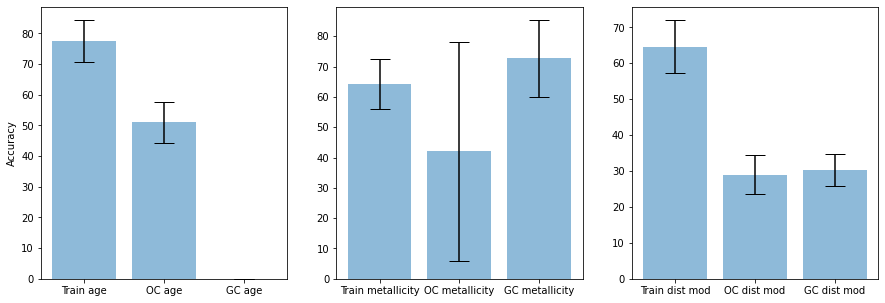

In [11]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

names = ['Train age', 'OC age', 'GC age']
x_pos = np.arange(len(names))

means = [acc_age_train.mean(),  acc_age_oc.mean(), acc_age_gc.mean()]
errors = [acc_age_train.std(),  acc_age_oc.std(), acc_age_gc.std()]

axs[0].bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(names)

names = ['Train metallicity', 'OC metallicity', 'GC metallicity']
means = [acc_z_train.mean(),  acc_z_oc.mean(), acc_z_gc.mean()]
errors = [acc_z_train.std(),  acc_z_oc.std(), acc_z_gc.std()]

axs[1].bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(names)

names = ['Train dist mod', 'OC dist mod', 'GC dist mod']
means = [acc_d_train.mean(),  acc_d_oc.mean(), acc_d_gc.mean()]
errors = [acc_d_train.std(),  acc_d_oc.std(), acc_d_gc.std()]

axs[2].bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
axs[2].set_xticks(x_pos)
axs[2].set_xticklabels(names)

plt.savefig("Graphs/distance_acc_bar.png")
plt.show()

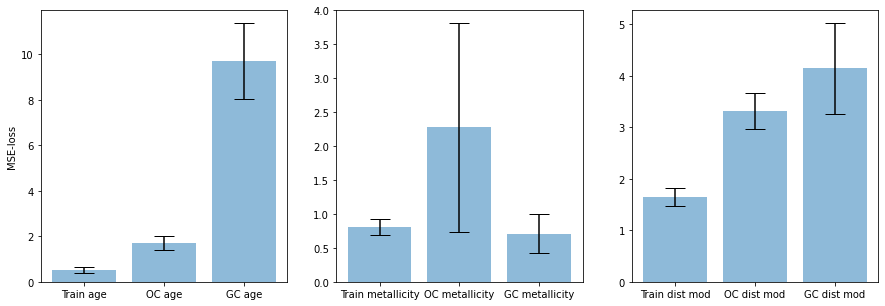

In [12]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

names = ['Train age', 'OC age', 'GC age']
x_pos = np.arange(len(names))

means = [mse_age_train.mean(),  mse_age_oc.mean(), mse_age_gc.mean()]
errors = [mse_age_train.std(),  mse_age_oc.std(), mse_age_gc.std()]

axs[0].bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
axs[0].set_ylabel('MSE-loss')
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(names)

names = ['Train metallicity', 'OC metallicity', 'GC metallicity']
means = [mse_z_train.mean(),  mse_z_oc.mean(), mse_z_gc.mean()]
errors = [mse_z_train.std(),  mse_z_oc.std(), mse_z_gc.std()]

axs[1].bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(names)

names = ['Train dist mod', 'OC dist mod', 'GC dist mod']
means = [mse_d_train.mean(),  mse_d_oc.mean(), mse_d_gc.mean()]
errors = [mse_d_train.std(),  mse_d_oc.std(), mse_d_gc.std()]

axs[2].bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
axs[2].set_xticks(x_pos)
axs[2].set_xticklabels(names)

plt.savefig("Graphs/distance_mse_bar.png")
plt.show()

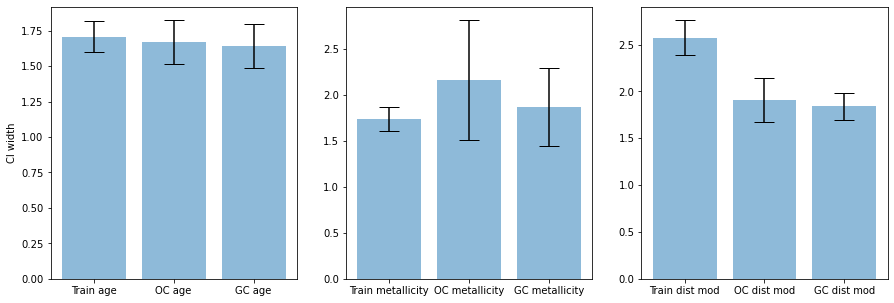

In [13]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

names = ['Train age', 'OC age', 'GC age']
x_pos = np.arange(len(names))

means = [ci_age_train.mean(),  ci_age_oc.mean(), ci_age_gc.mean()]
errors = [ci_age_train.std(),  ci_age_oc.std(), ci_age_gc.std()]

axs[0].bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
axs[0].set_ylabel('CI width')
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(names)

names = ['Train metallicity', 'OC metallicity', 'GC metallicity']
means = [ci_z_train.mean(),  ci_z_oc.mean(), ci_z_gc.mean()]
errors = [ci_z_train.std(),  ci_z_oc.std(), ci_z_gc.std()]

axs[1].bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(names)

names = ['Train dist mod', 'OC dist mod', 'GC dist mod']
means = [ci_d_train.mean(),  ci_d_oc.mean(), ci_d_gc.mean()]
errors = [ci_d_train.std(),  ci_d_oc.std(), ci_d_gc.std()]

axs[2].bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
axs[2].set_xticks(x_pos)
axs[2].set_xticklabels(names)

plt.savefig("Graphs/distance_ci_bar.png")
plt.show()